# Plot the posterior distribution of the best fitting model parameters for each chemical cell and their fits

In [43]:
import os
import sys

os.environ['DUST_DIR'] = '/Users/dhortadarrington/Packages/mwdust/'

import numpy as np
import matplotlib.pyplot as plt
import utils
import densprofiles
from galpy.util import coords
import mwdust
import tqdm
import emcee
import dill as pickle
import multiprocessing
from galpy.util import coords
import scipy.optimize as op
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from isodist import FEH2Z, Z2FEH
import corner
import safe_colours
import astropy.io.fits as fits

safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')

columnwidth = 240./72.27
textwidth = 504.0/72.27

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

os.environ['RESULTS_VERS'] = 'dr17'
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/dhortadarrington/Documents/Projects/halo-density/data/'
os.environ['ISODIST_DATA'] = '/Users/dhortadarrington/Packages/isodist/'


In [44]:
os.environ["PATH"]='/opt/homebrew/bin:/opt/homebrew/sbin:/Users/dhortadarrington/opt/\
    anaconda3/bin:/Users/dhortadarrington/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'


In [45]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
data = tb[1].data 

print(len(data))
mask = np.load('../sav/mask_parent.npy', allow_pickle=True)
mask_une = np.load('../sav/mask_unevolved.npy', allow_pickle=True)
print(len(data[mask]), len(data[mask&mask_une]))

733900
194257 4531


In [46]:
# lowfehbins = np.array([-3.,-1.6])
# lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[6.,18.] # from 0.1 to 40 kpc
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined19()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)

force = False
if os.path.exists('../sav/apogeeCombinedSF_DR17.dat') and not force:
    with open('../sav/apogeeCombinedSF_DR17.dat', 'rb') as f:
        apo = pickle.load(f)

if os.path.exists('../essf/effsel_grid_dr17-protoMW.dat') and not force:
    with open('../essf/effsel_grid_dr17-protoMW-2024.dat', 'rb') as f:
        outarea = pickle.load(f)


100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 18.83it/s]


In [47]:
apo.JKmax

<bound method apogeeCombinedSelect.JKmax of <apogee.select.apogeeSelect.apogeeCombinedSelect object at 0x43ee8d310>>

In [13]:
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)

import cmasher as cm
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8.178, Zsun=0.02)
    return XYZ, Rphiz
XYZ, Rphiz = allstar_to_coords(data)

In [14]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# remove fields in the bulge direction
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])
# bulgeindx = ((aposel_glons > 355) | (aposel_glons < 5)) & (np.fabs(aposel_glats) < 5)
# goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields
goodindx_eff = goodfields & (apo._locations != 5093) #remove bad fields
goodlocs = apo._locations[goodindx_eff]
# remove data not in the final field list
good_datamask = [data['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(data)))]
# good_datamask *= data['weighted_dist']/data['weighted_dist_error'] > 5.


  0%|          | 0/733900 [00:00<?, ?it/s]

In [70]:
# load the values
opt_plummer_cell1 = np.load('../sav/opt_plummer_tri_cell1.npy', allow_pickle=True)
lhood_plummer_cell1 = np.load('../sav/lhood_plummer_tri_cell1.npy', allow_pickle=True)
samples_plummer_cell1 = np.load('../sav/samples_plummer_tri_cell1.npy', allow_pickle=True)
sampler_plummer_cell1 = np.load('../sav/sampler_plummer_tri_cell1.npy', allow_pickle=True)
masses_plummer_cell1 = np.load('../sav/masses_plummer_tri_cell1.npy', allow_pickle=True)
facs_plummer_cell1 = np.load('../sav/facs_plummer_tri_cell1.npy', allow_pickle=True)

opt_plummer_cell2 = np.load('../sav/opt_plummer_tri_cell2.npy', allow_pickle=True)
lhood_plummer_cell2 = np.load('../sav/lhood_plummer_tri_cell2.npy', allow_pickle=True)
samples_plummer_cell2 = np.load('../sav/samples_plummer_tri_cell2.npy', allow_pickle=True)
sampler_plummer_cell2 = np.load('../sav/sampler_plummer_tri_cell2.npy', allow_pickle=True)
masses_plummer_cell2 = np.load('../sav/masses_plummer_tri_cell2.npy', allow_pickle=True)
facs_plummer_cell2 = np.load('../sav/facs_plummer_tri_cell2.npy', allow_pickle=True)

opt_plummer_cell3 = np.load('../sav/opt_plummer_tri_cell3.npy', allow_pickle=True)
lhood_plummer_cell3 = np.load('../sav/lhood_plummer_tri_cell3.npy', allow_pickle=True)
samples_plummer_cell3 = np.load('../sav/samples_plummer_tri_cell3.npy', allow_pickle=True)
sampler_plummer_cell3 = np.load('../sav/sampler_plummer_tri_cell3.npy', allow_pickle=True)
masses_plummer_cell3 = np.load('../sav/masses_plummer_tri_cell3.npy', allow_pickle=True)
facs_plummer_cell3 = np.load('../sav/facs_plummer_tri_cell3.npy', allow_pickle=True)


In [71]:
opt_plummer_comb = np.load('../sav/opt_plummer_tri_combined1through3.npy', allow_pickle=True)
lhood_plummer_comb = np.load('../sav/lhood_plummer_tri_combined1through3.npy', allow_pickle=True)
samples_plummer_comb = np.load('../sav/samples_plummer_tri_combined1through3.npy', allow_pickle=True)
sampler_plummer_comb = np.load('../sav/sampler_plummer_tri_combined1through3.npy', allow_pickle=True)
masses_plummer_comb = np.load('../sav/masses_plummer_tri_combined1through3.npy', allow_pickle=True)
facs_plummer_comb = np.load('../sav/facs_plummer_tri_combined1through3.npy', allow_pickle=True)

In [47]:
percen_comb = np.percentile(samples_plummer_comb, [16,50,84],axis=0)

In [48]:
percen_comb

array([[3.3866145 , 0.76879767, 0.64159454],
       [3.48271174, 0.79963316, 0.66068138],
       [3.58167114, 0.8332481 , 0.68105021]])

In [13]:
np.mean(facs_plummer_cell1),np.mean(facs_plummer_cell2),np.mean(facs_plummer_cell3)

(54244.5437383174, 149670.03437428718, 9248.84670844439)

In [76]:
print(np.mean(masses_plummer_cell3))

118071155.09967405


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


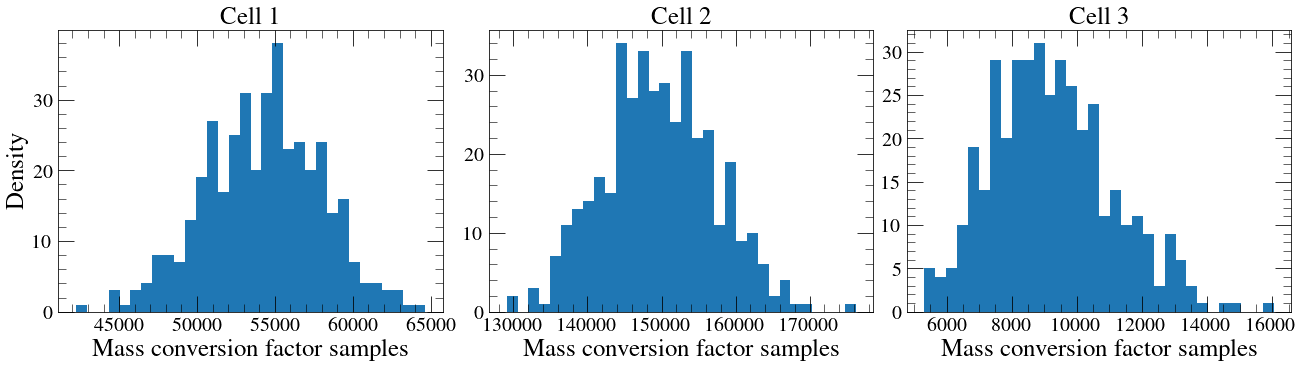

In [18]:
plt.figure(figsize=(18,5), facecolor='white', constrained_layout=True)

plt.subplot(1,3,1)
plt.title('Cell 1', fontsize=25)
plt.hist(facs_plummer_cell1, 32)
plt.xlabel('Mass conversion factor samples', fontsize=25)
plt.ylabel('Density', fontsize=25)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
plt.title('Cell 2', fontsize=25)
plt.hist(facs_plummer_cell2, 32)
plt.xlabel('Mass conversion factor samples', fontsize=25)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,3)
plt.title('Cell 3', fontsize=25)
plt.hist(facs_plummer_cell3, 32)
plt.xlabel('Mass conversion factor samples', fontsize=25)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()



In [8]:
# load the values
opt_halo_cell4 = np.load('../sav/opt_halo_cell4.npy', allow_pickle=True)
lhood_halo_cell4 = np.load('../sav/lhood_halo_cell4.npy', allow_pickle=True)
samples_halo_cell4 = np.load('../sav/samples_halo_cell4.npy', allow_pickle=True)
sampler_halo_cell4 = np.load('../sav/sampler_halo_cell4.npy', allow_pickle=True)
masses_halo_cell4 = np.load('../sav/masses_halo_cell4.npy', allow_pickle=True)
facs_halo_cell4 = np.load('../sav/facs_halo_cell4.npy', allow_pickle=True)

opt_halo_cell5 = np.load('../sav/opt_halo_cell5.npy', allow_pickle=True)
lhood_halo_cell5 = np.load('../sav/lhood_halo_cell5.npy', allow_pickle=True)
samples_halo_cell5 = np.load('../sav/samples_halo_cell5.npy', allow_pickle=True)
sampler_halo_cell5 = np.load('../sav/sampler_halo_cell5.npy', allow_pickle=True)
masses_halo_cell5 = np.load('../sav/masses_halo_cell5.npy', allow_pickle=True)
facs_halo_cell5 = np.load('../sav/facs_halo_cell5.npy', allow_pickle=True)

opt_halo_cell6 = np.load('../sav/opt_halo_cell6.npy', allow_pickle=True)
lhood_halo_cell6 = np.load('../sav/lhood_halo_cell6.npy', allow_pickle=True)
samples_halo_cell6 = np.load('../sav/samples_halo_cell6.npy', allow_pickle=True)
sampler_halo_cell6 = np.load('../sav/sampler_halo_cell6.npy', allow_pickle=True)
masses_halo_cell6 = np.load('../sav/masses_halo_cell6.npy', allow_pickle=True)
facs_halo_cell6 = np.load('../sav/facs_halo_cell6.npy', allow_pickle=True)


In [9]:
np.median(samples_halo_cell5,axis=0)

array([1.44267114, 0.0142259 , 0.77701201, 0.46457435, 0.01496054,
       0.20114482, 0.49621427, 0.45052287])

In [13]:
np.nanmedian(masses_halo_cell5[:,0])

6375262044.8295965

In [14]:
# load the values
opt_halo_cell7 = np.load('../sav/opt_halo_cell7.npy', allow_pickle=True)
lhood_halo_cell7 = np.load('../sav/lhood_halo_cell7.npy', allow_pickle=True)
samples_halo_cell7 = np.load('../sav/samples_halo_cell7.npy', allow_pickle=True)
sampler_halo_cell7 = np.load('../sav/sampler_halo_cell7.npy', allow_pickle=True)
masses_halo_cell7 = np.load('../sav/masses_halo_cell7.npy', allow_pickle=True)
facs_halo_cell7 = np.load('../sav/facs_halo_cell7.npy', allow_pickle=True)

opt_halo_cell8 = np.load('../sav/opt_halo_cell8.npy', allow_pickle=True)
lhood_halo_cell8 = np.load('../sav/lhood_halo_cell8.npy', allow_pickle=True)
samples_halo_cell8 = np.load('../sav/samples_halo_cell8.npy', allow_pickle=True)
sampler_halo_cell8 = np.load('../sav/sampler_halo_cell8.npy', allow_pickle=True)
masses_halo_cell8 = np.load('../sav/masses_halo_cell8.npy', allow_pickle=True)
facs_halo_cell8 = np.load('../sav/facs_halo_cell8.npy', allow_pickle=True)

opt_halo_cell9 = np.load('../sav/opt_halo_cell9.npy', allow_pickle=True)
lhood_halo_cell9 = np.load('../sav/lhood_halo_cell9.npy', allow_pickle=True)
samples_halo_cell9 = np.load('../sav/samples_halo_cell9.npy', allow_pickle=True)
sampler_halo_cell9 = np.load('../sav/sampler_halo_cell9.npy', allow_pickle=True)
masses_halo_cell9 = np.load('../sav/masses_halo_cell9.npy', allow_pickle=True)
facs_halo_cell9 = np.load('../sav/facs_halo_cell9.npy', allow_pickle=True)


# First plot the fits

In [20]:
c1 = np.load('../sav/mask_c1.npy',allow_pickle=True)
c2 = np.load('../sav/mask_c2.npy',allow_pickle=True)
c3 = np.load('../sav/mask_c3.npy',allow_pickle=True)
c4 = np.load('../sav/mask_c4.npy',allow_pickle=True)
c5 = np.load('../sav/mask_c5.npy',allow_pickle=True)
c6 = np.load('../sav/mask_c6.npy',allow_pickle=True)
c7 = np.load('../sav/mask_c7.npy',allow_pickle=True)
c8 = np.load('../sav/mask_c8.npy',allow_pickle=True)
c9 = np.load('../sav/mask_c9.npy',allow_pickle=True)
masks_c = [c1, c2, c3, c4, c5, c6, c7, c8, c9]

In [21]:
rads = np.sqrt((data['Rgal']*8.275)**2 + (data['Zgal']*8.275)**2)

(array([ 8.,  7.,  5.,  2.,  3., 11.,  5.,  6.,  4.,  6.]),
 array([ 0.47104457,  1.58921349,  2.70738241,  3.82555132,  4.94372024,
         6.06188916,  7.18005808,  8.29822699,  9.41639591, 10.53456483,
        11.65273375]),
 <BarContainer object of 10 artists>)

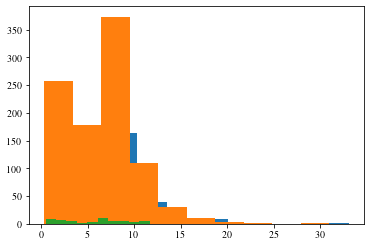

In [22]:
plt.hist(rads[c1])
plt.hist(rads[c2])
plt.hist(rads[c3])

In [23]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params))*effsel[goodindx_eff]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd


In [26]:
mask_tot = np.any([c1, c2, c3], axis=0)


In [29]:
cell1pd = check_fit(masks_c[0], samples_plummer_cell1, outarea, densprofiles.plummer_axi, distmods, sample=True)
cell2pd = check_fit(masks_c[1], samples_plummer_cell2, outarea, densprofiles.plummer_axi, distmods, sample=True)
cell3pd = check_fit(masks_c[2], samples_plummer_cell3, outarea, densprofiles.plummer_axi, distmods, sample=True)


341


  0%|          | 0/200 [00:00<?, ?it/s]

965


  0%|          | 0/200 [00:00<?, ?it/s]

57


  0%|          | 0/200 [00:00<?, ?it/s]

In [30]:
cellallpd = check_fit(mask_tot, samples_plummer_comb, outarea, densprofiles.plummer_axi, distmods, sample=True)


1363


  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
cell4pd = check_fit(masks_c[3], samples_halo_cell4, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
cell5pd = check_fit(masks_c[4], samples_halo_cell5, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
cell6pd = check_fit(masks_c[5], samples_halo_cell6, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
cell7pd = check_fit(masks_c[6], samples_halo_cell7, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
cell8pd = check_fit(masks_c[7], samples_halo_cell8, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
cell9pd = check_fit(masks_c[8], samples_halo_cell9, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)


386


  0%|          | 0/200 [00:00<?, ?it/s]

1955


  0%|          | 0/200 [00:00<?, ?it/s]

485


  0%|          | 0/200 [00:00<?, ?it/s]

28


  0%|          | 0/200 [00:00<?, ?it/s]

104


  0%|          | 0/200 [00:00<?, ?it/s]

160


  0%|          | 0/200 [00:00<?, ?it/s]

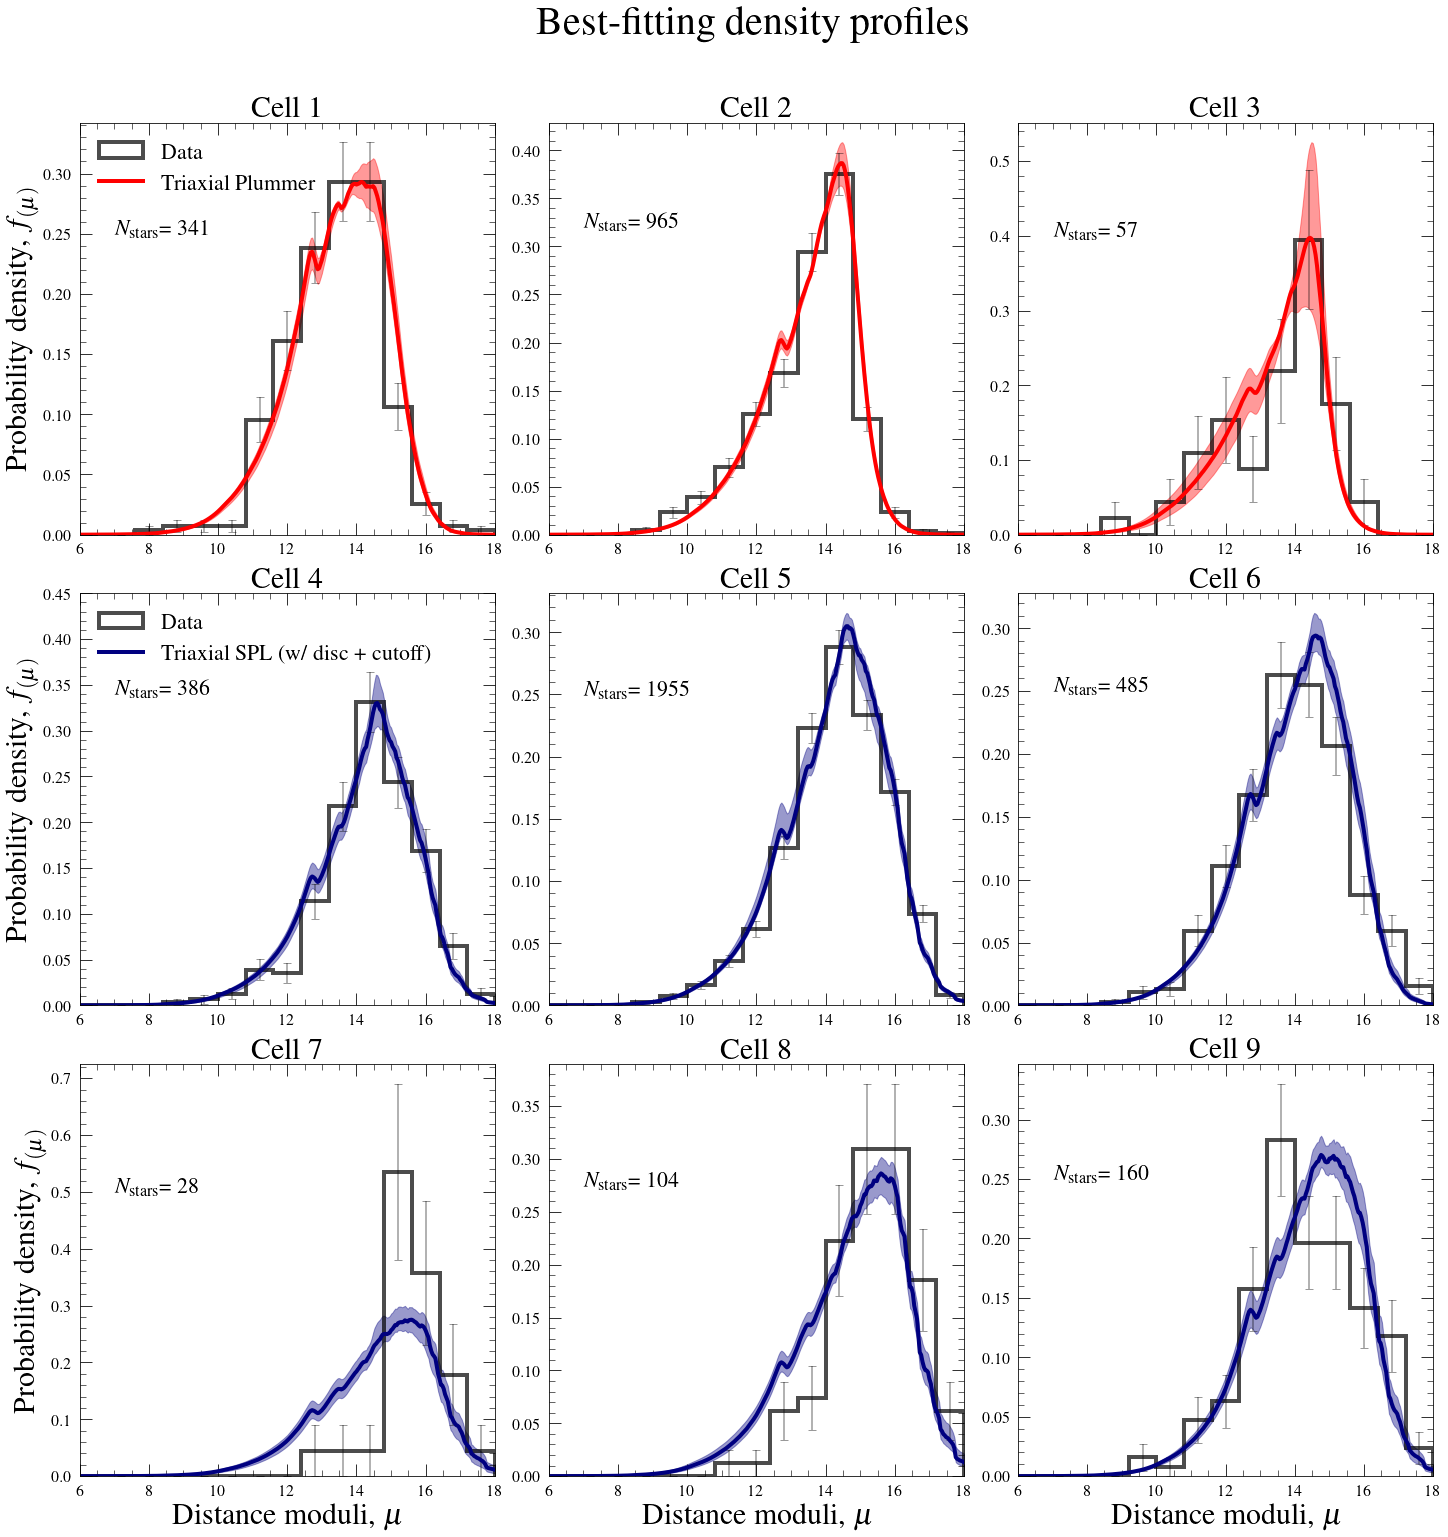

In [21]:
fig = plt.figure(figsize=(20,20), facecolor='white', constrained_layout=True)

fig.suptitle('Best-fitting density profiles',fontsize=40,x=0.52,y=1.06)


n = 16

plt.subplot(3,3,1)
i = 0
plt.title('Cell 1', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell1pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell1pd,5,axis=0),np.nanpercentile(cell1pd,95,axis=0), color='r', alpha=0.4)
plt.legend(frameon=False,loc='upper left', fontsize=22)
plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,2)
i = 1
plt.title('Cell 2', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell2pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell2pd,5,axis=0),np.nanpercentile(cell2pd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.32, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,3)
i = 2
plt.title('Cell 3', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell3pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell3pd,5,axis=0),np.nanpercentile(cell3pd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.4, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,4)
i = 3
plt.title('Cell 4', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell4pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
plt.fill_between(distmods,np.nanpercentile(cell4pd,5,axis=0),np.nanpercentile(cell4pd,95,axis=0), color='navy', alpha=0.4)
plt.text(7, 0.34, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
plt.legend(frameon=False,loc='upper left', fontsize=22)
plt.xlim(6,18)
plt.ylim(0,0.45)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,5)
i = 4
plt.title('Cell 5', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell5pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.fill_between(distmods,np.nanpercentile(cell5pd,5,axis=0),np.nanpercentile(cell5pd,95,axis=0), color='navy', alpha=0.4)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,6)
i = 5
plt.title('Cell 6', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell6pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.fill_between(distmods,np.nanpercentile(cell6pd,5,axis=0),np.nanpercentile(cell6pd,95,axis=0), color='navy', alpha=0.4)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,7)
i = 6
plt.title('Cell 7', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell7pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
plt.text(7, 0.5, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.fill_between(distmods,np.nanpercentile(cell7pd,5,axis=0),np.nanpercentile(cell7pd,95,axis=0), color='navy', alpha=0.4)
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,8)
i = 7
plt.title('Cell 8', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell8pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
plt.fill_between(distmods,np.nanpercentile(cell8pd,5,axis=0),np.nanpercentile(cell8pd,95,axis=0), color='navy', alpha=0.4)
plt.text(7, 0.275, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,9)
i = 8
plt.title('Cell 9', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell9pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
plt.fill_between(distmods,np.nanpercentile(cell9pd,5,axis=0),np.nanpercentile(cell9pd,95,axis=0), color='navy', alpha=0.4)
plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

# plt.savefig('../plots/best-fits-cells.pdf', format='pdf', dpi=200, bbox_inches='tight')


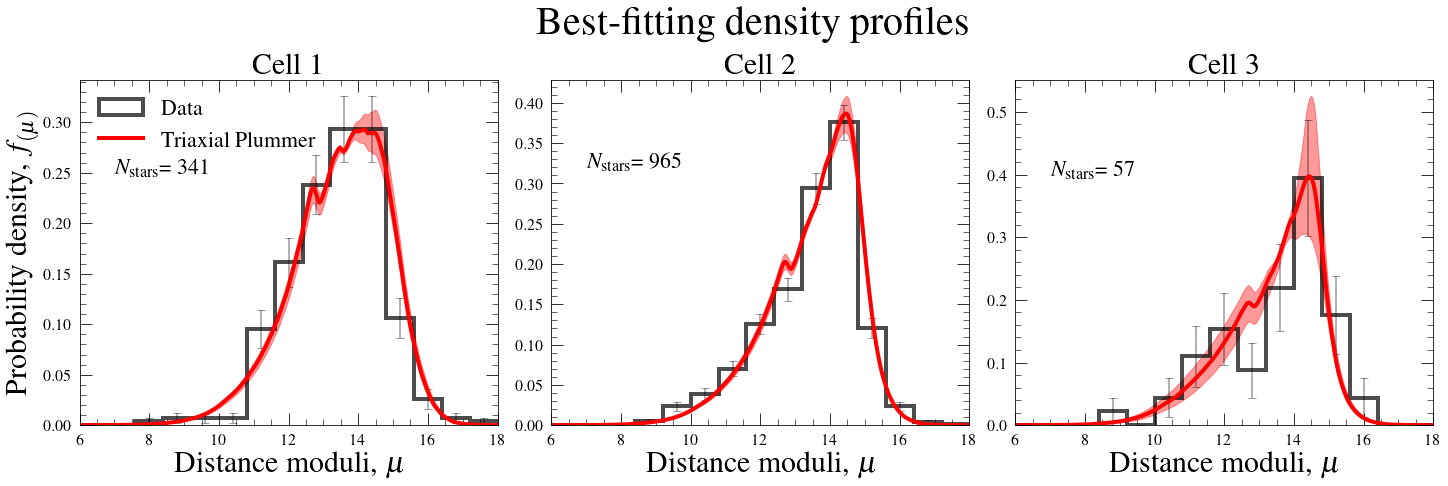

In [22]:
fig = plt.figure(figsize=(20,6), facecolor='white', constrained_layout=True)

fig.suptitle('Best-fitting density profiles',fontsize=40,x=0.52,y=1.1)


n = 16

plt.subplot(1,3,1)
i = 0
plt.title('Cell 1', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell1pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell1pd,5,axis=0),np.nanpercentile(cell1pd,95,axis=0), color='r', alpha=0.4)
plt.legend(frameon=False,loc='upper left', fontsize=22)
plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)

plt.subplot(1,3,2)
i = 1
plt.title('Cell 2', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell2pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell2pd,5,axis=0),np.nanpercentile(cell2pd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.32, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)

plt.subplot(1,3,3)
i = 2
plt.title('Cell 3', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell3pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell3pd,5,axis=0),np.nanpercentile(cell3pd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.4, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)

# plt.subplot(3,3,4)
# i = 3
# plt.title('Cell 4', fontsize=30)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
# bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
# dens = y/(np.sum(y)* np.diff(bin_edges))
# plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
# plt.plot(distmods,np.nanpercentile(cell4pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
# plt.fill_between(distmods,np.nanpercentile(cell4pd,5,axis=0),np.nanpercentile(cell4pd,95,axis=0), color='navy', alpha=0.4)
# plt.text(7, 0.34, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
# plt.legend(frameon=False,loc='upper left', fontsize=22)
# plt.xlim(6,18)
# plt.ylim(0,0.45)
# plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# plt.minorticks_on()

# plt.subplot(3,3,5)
# i = 4
# plt.title('Cell 5', fontsize=30)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
# bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
# dens = y/(np.sum(y)* np.diff(bin_edges))
# plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
# plt.plot(distmods,np.nanpercentile(cell5pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
# plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.fill_between(distmods,np.nanpercentile(cell5pd,5,axis=0),np.nanpercentile(cell5pd,95,axis=0), color='navy', alpha=0.4)
# plt.xlim(6,18)
# plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# plt.minorticks_on()

# plt.subplot(3,3,6)
# i = 5
# plt.title('Cell 6', fontsize=30)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
# bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
# dens = y/(np.sum(y)* np.diff(bin_edges))
# plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
# plt.plot(distmods,np.nanpercentile(cell6pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
# plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.fill_between(distmods,np.nanpercentile(cell6pd,5,axis=0),np.nanpercentile(cell6pd,95,axis=0), color='navy', alpha=0.4)
# plt.xlim(6,18)
# plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# plt.minorticks_on()

# plt.subplot(3,3,7)
# i = 6
# plt.title('Cell 7', fontsize=30)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
# bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
# dens = y/(np.sum(y)* np.diff(bin_edges))
# plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
# plt.plot(distmods,np.nanpercentile(cell7pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
# plt.text(7, 0.5, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.fill_between(distmods,np.nanpercentile(cell7pd,5,axis=0),np.nanpercentile(cell7pd,95,axis=0), color='navy', alpha=0.4)
# plt.xlabel('Distance moduli, $\mu$',fontsize=30)
# plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
# plt.xlim(6,18)
# plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# plt.minorticks_on()

# plt.subplot(3,3,8)
# i = 7
# plt.title('Cell 8', fontsize=30)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
# bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
# dens = y/(np.sum(y)* np.diff(bin_edges))
# plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
# plt.plot(distmods,np.nanpercentile(cell8pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
# plt.fill_between(distmods,np.nanpercentile(cell8pd,5,axis=0),np.nanpercentile(cell8pd,95,axis=0), color='navy', alpha=0.4)
# plt.text(7, 0.275, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.xlabel('Distance moduli, $\mu$',fontsize=30)
# plt.xlim(6,18)
# plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# plt.minorticks_on()

# plt.subplot(3,3,9)
# i = 8
# plt.title('Cell 9', fontsize=30)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
# bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
# dens = y/(np.sum(y)* np.diff(bin_edges))
# plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
# plt.plot(distmods,np.nanpercentile(cell9pd,50,axis=0),lw=4, color='navy', label=r'Triaxial SPL (w/ disc + cutoff)')
# plt.fill_between(distmods,np.nanpercentile(cell9pd,5,axis=0),np.nanpercentile(cell9pd,95,axis=0), color='navy', alpha=0.4)
# plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.xlabel('Distance moduli, $\mu$',fontsize=30)
# plt.xlim(6,18)
# plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# plt.minorticks_on()

plt.savefig('../plots/best-fits-cells1-3.pdf', format='pdf', dpi=200, bbox_inches='tight')


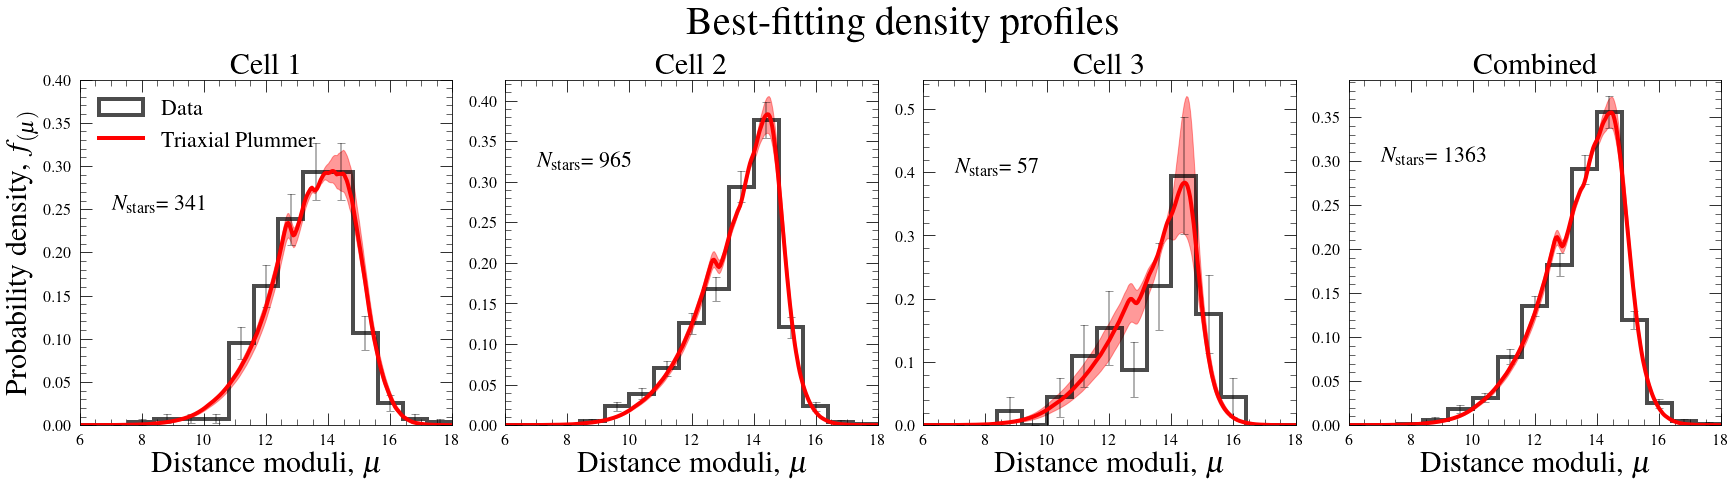

In [36]:
fig = plt.figure(figsize=(24,6), facecolor='white', constrained_layout=True)

fig.suptitle('Best-fitting density profiles',fontsize=40,x=0.52,y=1.1)


n = 16

plt.subplot(1,4,1)
i = 0
plt.title('Cell 1', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell1pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell1pd,5,axis=0),np.nanpercentile(cell1pd,95,axis=0), color='r', alpha=0.4)
plt.legend(frameon=False,loc='upper left', fontsize=22)
plt.text(7, 0.25, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=30)
plt.xlim(6,18)
plt.ylim(0,0.4)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)

plt.subplot(1,4,2)
i = 1
plt.title('Cell 2', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell2pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell2pd,5,axis=0),np.nanpercentile(cell2pd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.32, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)

plt.subplot(1,4,3)
i = 2
plt.title('Cell 3', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cell3pd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cell3pd,5,axis=0),np.nanpercentile(cell3pd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.4, '$N_{\mathrm{stars}}$= '+str(len(data[masks_c[i]])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)

plt.subplot(1,4,4)
plt.title('Combined', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][mask_tot]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.4)
plt.plot(distmods,np.nanpercentile(cellallpd,50,axis=0),lw=4, color='r', label=r'Triaxial Plummer')
plt.fill_between(distmods,np.nanpercentile(cellallpd,5,axis=0),np.nanpercentile(cellallpd,95,axis=0), color='r', alpha=0.4)
plt.text(7, 0.3, '$N_{\mathrm{stars}}$= '+str(len(data[mask_tot])), fontsize=22)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlabel('Distance moduli, $\mu$',fontsize=30)


plt.savefig('../plots/best-fits-cells1-3-plusall.pdf', format='pdf', dpi=200, bbox_inches='tight')


# Now plot the samples of the parameters for cells 1, 2, and 3

In [59]:
from matplotlib.colors import LogNorm

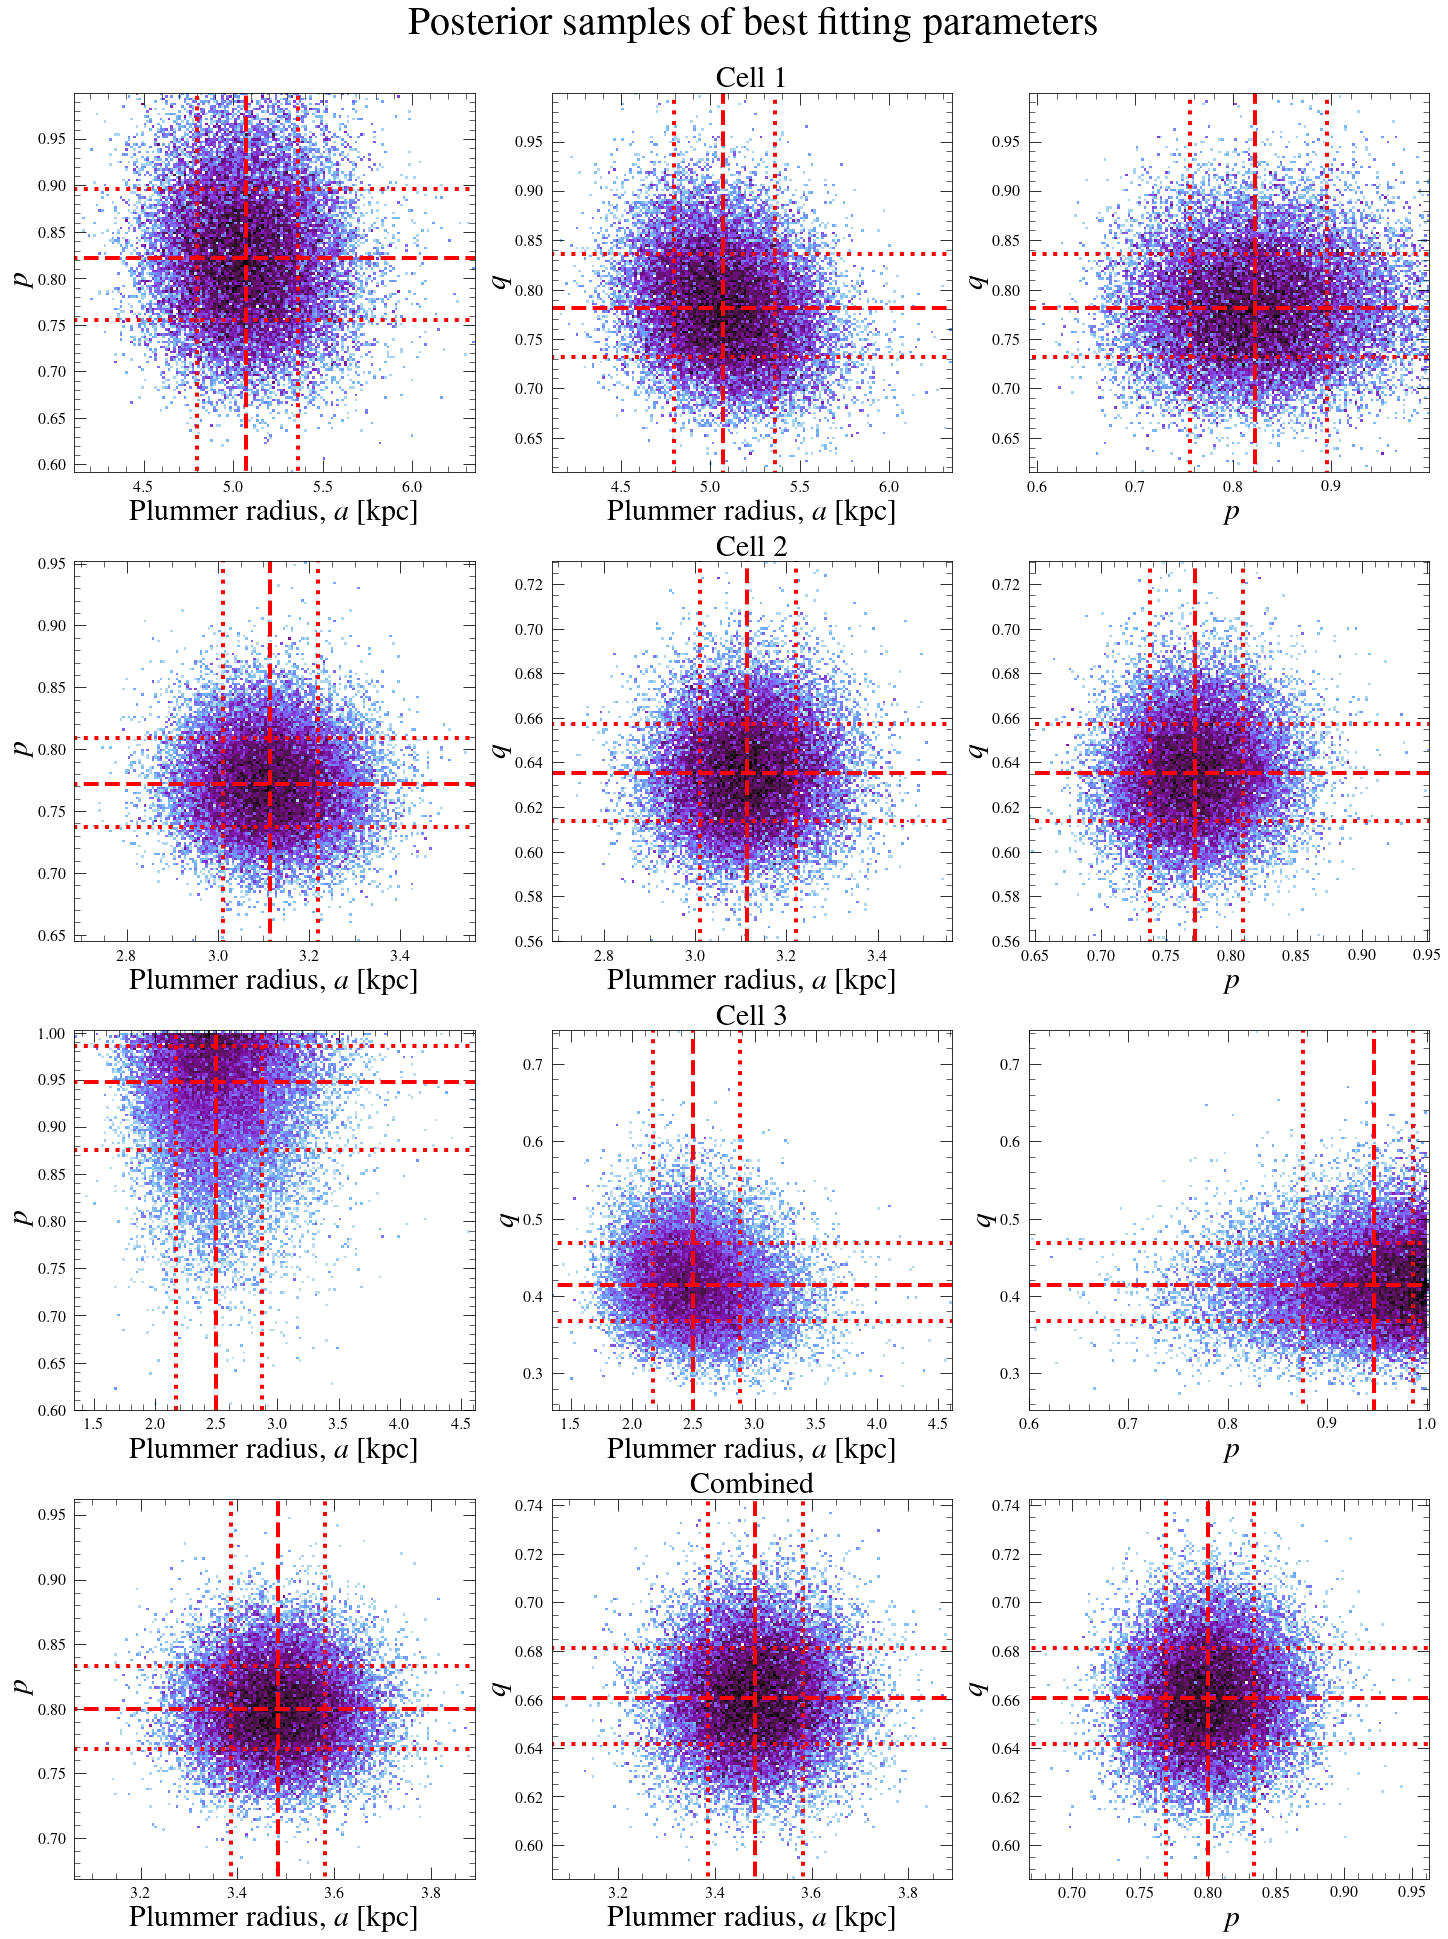

In [63]:
fig = plt.figure(figsize=(20,26), facecolor='white', constrained_layout=True)

fig.suptitle('Posterior samples of best fitting parameters',fontsize=40,x=0.52,y=1.03)

plt.subplot(4,3,1)
# plt.title('Cell 1', fontsize=24)
percen = np.percentile(samples_plummer_cell1, [16,50,84], axis=0)
plt.hist2d(samples_plummer_cell1[:,0], samples_plummer_cell1[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,1], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,1], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,1], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$p$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,2)
plt.title('Cell 1', fontsize=30)
plt.hist2d(samples_plummer_cell1[:,0], samples_plummer_cell1[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,3)
# plt.title('Cell 3', fontsize=24)
plt.hist2d(samples_plummer_cell1[:,1], samples_plummer_cell1[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,1], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,1], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,1], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 1, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 1, color='r', lw=4, ls='dotted')
plt.xlabel('$p$', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,4)
# plt.title('Cell 1', fontsize=24)
percen = np.percentile(samples_plummer_cell2, [16,50,84], axis=0)
plt.hist2d(samples_plummer_cell2[:,0], samples_plummer_cell2[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,1], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,1], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,1], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$p$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,5)
plt.title('Cell 2', fontsize=30)
plt.hist2d(samples_plummer_cell2[:,0], samples_plummer_cell2[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,6)
# plt.title('Cell 3', fontsize=24)
plt.hist2d(samples_plummer_cell2[:,1], samples_plummer_cell2[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,1], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,1], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,1], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 1, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 1, color='r', lw=4, ls='dotted')
plt.xlabel('$p$', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,7)
# plt.title('Cell 1', fontsize=24)
percen = np.percentile(samples_plummer_cell3, [16,50,84], axis=0)
plt.hist2d(samples_plummer_cell3[:,0], samples_plummer_cell3[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,1], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,1], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,1], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$p$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,8)
plt.title('Cell 3', fontsize=30)
plt.hist2d(samples_plummer_cell3[:,0], samples_plummer_cell3[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,9)
# plt.title('Cell 3', fontsize=24)
plt.hist2d(samples_plummer_cell3[:,1], samples_plummer_cell3[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,1], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,1], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,1], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 1, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 1, color='r', lw=4, ls='dotted')
plt.xlabel('$p$', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,10)
# plt.title('Cell 1', fontsize=24)
percen = np.percentile(samples_plummer_comb, [16,50,84], axis=0)
plt.hist2d(samples_plummer_comb[:,0], samples_plummer_comb[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,1], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,1], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,1], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$p$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,11)
plt.title('Combined', fontsize=30)
plt.hist2d(samples_plummer_comb[:,0], samples_plummer_comb[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,0], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,0], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 10, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 10, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 10, color='r', lw=4, ls='dotted')
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(4,3,12)
# plt.title('Cell 3', fontsize=24)
plt.hist2d(samples_plummer_comb[:,1], samples_plummer_comb[:,2], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,1], 0, 1, color='r', lw=4, ls='--')
plt.vlines(percen[0,1], 0, 1, color='r', lw=4, ls='dotted')
plt.vlines(percen[2,1], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[1,2], 0, 1, color='r', lw=4, ls='--')
plt.hlines(percen[0,2], 0, 1, color='r', lw=4, ls='dotted')
plt.hlines(percen[2,2], 0, 1, color='r', lw=4, ls='dotted')
plt.xlabel('$p$', fontsize=30)
plt.ylabel('$q$', fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.savefig('../plots/best-params-cells.pdf', format='pdf', dpi=200, bbox_inches='tight')


In [25]:
a = np.percentile(samples_plummer_cell3, [16,50,84], axis=0)
print(a)

[[2.17071102 0.87532927 0.36753064]
 [2.49705654 0.94708168 0.41465543]
 [2.87648789 0.9862573  0.4682355 ]]


In [26]:
opt_halo_cell5

array([1.68760696e+00, 1.00000046e-02, 9.99999831e-01, 9.99994342e-01,
       3.42250269e-03, 7.56087286e-04, 2.77693133e-03, 2.38293615e-03])

# Now plot cells 1, 2, and 3 together

# Plot the spatial distribution of the data

In [27]:
# lowfehbins = np.array([-3.,-1.6])
# lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[6.,18.] # from 0.1 to 40 kpc
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined19()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)

force = False
if os.path.exists('../sav/apogeeCombinedSF_DR17.dat') and not force:
    with open('../sav/apogeeCombinedSF_DR17.dat', 'rb') as f:
        apo = pickle.load(f)

if os.path.exists('../essf/effsel_grid_dr17-protoMW.dat') and not force:
    with open('../essf/effsel_grid_dr17-protoMW-2024.dat', 'rb') as f:
        outarea = pickle.load(f)


100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 31.61it/s]


In [28]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# remove fields in the bulge direction
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])
# bulgeindx = ((aposel_glons > 355) | (aposel_glons < 5)) & (np.fabs(aposel_glats) < 5)
# goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields
goodindx_eff = goodfields & (apo._locations != 5093) #remove bad fields
goodlocs = apo._locations[goodindx_eff]
# remove data not in the final field list
good_datamask = [data['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(data)))]
# good_datamask *= data['weighted_dist']/data['weighted_dist_error'] > 5.


  0%|          | 0/733900 [00:00<?, ?it/s]

In [29]:
#Coordinates from the Selection Function
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])
ndists = np.linspace(0.1, 40, len(aposel_glons))


In [30]:
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(glon, glat, dist):
    XYZ = coords.lbd_to_XYZ(glon, glat, dist, degree=True)
    Rphiz = coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8.275, Zsun=0.02)
    return XYZ, Rphiz
XYZ, Rphiz = allstar_to_coords(aposel_glons, aposel_glats, ndists)

(-20.0, 20.0)

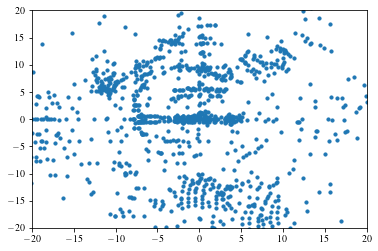

In [31]:
plt.scatter(XYZ[:,0][goodindx_eff], XYZ[:,2][goodindx_eff], s=10)
plt.xlim(-20,20)
plt.ylim(-20,20)

In [32]:
a = opt_plummer_cell2[0]
p = opt_plummer_cell2[1]
q = opt_plummer_cell2[2]

# Convert from cylindrical coords to cartesian
x,y,z = R*np.cos(phi), R*np.sin(phi), z
x_sun, y_sun, z_sun = _R0, 0., _z0

NameError: name 'R' is not defined

In [48]:
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

(array([ 374.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1573.]),
 array([8.00000012e-01, 1.00620000e+02, 2.00440000e+02, 3.00260000e+02,
        4.00080000e+02, 4.99900000e+02, 5.99720000e+02, 6.99540000e+02,
        7.99360000e+02, 8.99180000e+02, 9.99000000e+02]),
 <BarContainer object of 10 artists>)

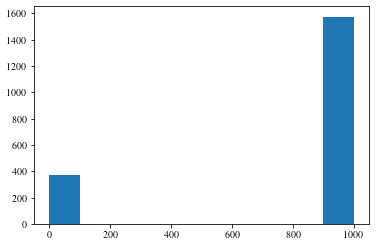

In [52]:
plt.hist(jkmaxs)

# now make the Tinsley diagram coloured by the mass in each cell

In [53]:
# isofactors = np.zeros(len(effsel[goodindx_eff]))
# for i in range(len(isofactors)):   
fehrange=[-2.,-1.]
isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx_eff][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 4000.)& (10**(isorec['logTe']) < 5500.)
avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
isomask1 = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
massratio = utils.mass_ratio(isorec[isomask1], lowfehgrid=True, minjk=jkmins[goodindx_eff][i])
# isofactors[i] = avmass/massratio

Text(0.5, 0, 'min($J-K_{0}$)')

python(57855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


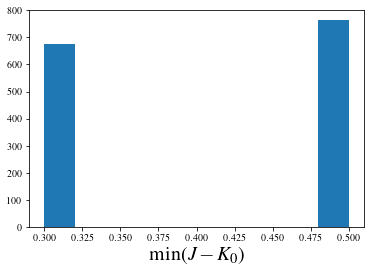

In [62]:
plt.hist(jkmins[goodindx_eff])
plt.xlabel(r'min($J-K_{0}$)', fontsize=20)

In [89]:
#first need to get the minimum J-K in each field
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

def normalisation_from_fixed_profile(mask, effsel, model, params, fehrange=[-2.,-1.], fixnorm=None):
    '''
    computes the normalisation or mass from the APOGEE star counts for a fixed profile
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    params - parameters of the input density model (fixed)
    fehrange - the range in Fe/H spanned by the sample defined by mask
    fixnorm - fix normalisation to one (supplied) value (instead of using APOGEE star counts)
    OUTPUT:
    fac - the normalisation factor (returns fixnorm if set)
    mass - the mass for the input parameters 
    norm - normalisation factor
    '''
    isofactors = np.zeros(len(effsel[goodindx_eff]))
    for i in range(len(isofactors)):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx_eff][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 4000.)& (10**(isorec['logTe']) < 5500.)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx_eff][i])
        isofactors[i] = avmass/massratio
    rthetaphigrid = np.mgrid[0.1:10.:200j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (10.-0.1)/199
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    shape = np.shape(rthetaphigrid.T)
    rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
    deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
    x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
    y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
    z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
    xyzgrid = np.dstack([x,y,z])[0]
    rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rate = model(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params)*effsel[goodindx_eff]*ds**3*(distmods[1]-distmods[0])
    sumrate = np.sum(rate.T/isofactors)
    norm = sum(mask)/sumrate
    fac = norm*(180./np.pi)**2
    if fixnorm is not None:
        fac = fixnorm*(1e3)**3
    if model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
        denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
        halodens = denstxyz[0]*fac
        diskdens = denstxyz[1]*fac
        fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
        mass = np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor), np.sum(fulldens*deltafactor)
    else:
        denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
        mass =  np.sum(denstxyz*deltafactor)
    return fac, mass, norm, isofactors, denstxyz


In [38]:
# test 
indx = mask&mask_une&(data['ecc']>0.7)&(data['FE_H']<-1)&(data['LOGG']<1)
par = [1.57287966e+00, 6.33518405e-02, 5.73907764e-01, 7.98672389e-01, 5.43331592e-10, 4.64845040e-04, 5.23788127e-07, 8.70503921e-03]
fac_t, mass_t, norm_t, t_halo = normalisation_from_fixed_profile(indx, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  par, fehrange=[-2.5,-1.])



In [17]:
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

In [38]:
isofactors = np.zeros(len(outarea[goodindx_eff]))
for i in range(len(isofactors)):   
    isomask1 = (Z2FEH(isorec['Zini']) > -2.5) & (Z2FEH(isorec['Zini']) < -1) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx_eff][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 4000.)& (10**(isorec['logTe']) < 5500.)
    avmass = utils.average_mass(isorec[isomask1], lowfehgrid=True)
    isomask2 = (Z2FEH(isorec['Zini']) > -2.5) & (Z2FEH(isorec['Zini']) < -1) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
    massratio = utils.mass_ratio(isorec[isomask2], lowfehgrid=True, minjk=jkmins[goodindx_eff][i])
    isofactors[i] = avmass/massratio
    

(array([677.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 764.]),
 array([174.72758294, 207.86526127, 241.0029396 , 274.14061793,
        307.27829626, 340.41597459, 373.55365291, 406.69133124,
        439.82900957, 472.9666879 , 506.10436623]),
 <BarContainer object of 10 artists>)

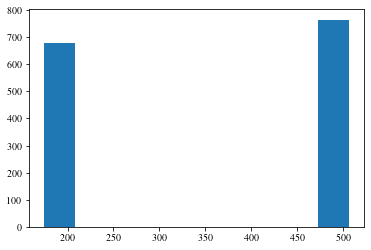

# If you include an eccentricity cut, you remove a bunch of mass from the estimate of the GES

In [78]:
R = data['Rgal']*8.275
z = data['z']*8.275
rads = np.sqrt(R**2+z**2)


In [79]:
# integrate the mass within 15 kpc

In [80]:
opt_plummer_cell1

array([5.05364242, 0.81682921, 0.77921362])

In [90]:
fac1, mass1, norm1, isofacs1, t1 = normalisation_from_fixed_profile(masks_c[0], outarea, densprofiles.plummer_axi,\
                                                  opt_plummer_cell1, fehrange=[-2.,-1.5])

fac2, mass2, norm2, isofacs2, t2 = normalisation_from_fixed_profile(masks_c[1], outarea, densprofiles.plummer_axi,\
                                                  opt_plummer_cell2, fehrange=[-1.5,-1.])

fac3, mass3, norm3, isofacs3, t3 = normalisation_from_fixed_profile(masks_c[2], outarea, densprofiles.plummer_axi,\
                                                  opt_plummer_cell3, fehrange=[-1.,-0.5])


In [91]:
fac_comb, mass_comb, norm_comb, isofacs_comb, t_comb = normalisation_from_fixed_profile(mask_tot, outarea, densprofiles.plummer_axi,\
                                                  opt_plummer_comb, fehrange=[-2.,-0.5])

In [96]:
# normalisation factors
np.save('../sav/facs_plummer_tri_cell1', fac1)
np.save('../sav/facs_plummer_tri_cell2', fac2)
np.save('../sav/facs_plummer_tri_cell3', fac3)
np.save('../sav/facs_plummer_tri_cell_comb', fac_comb)

# raw normalisation factors
np.save('../sav/norm_plummer_tri_cell1', norm1)
np.save('../sav/norm_plummer_tri_cell2', norm2)
np.save('../sav/norm_plummer_tri_cell3', norm3)
np.save('../sav/norm_plummer_tri_cell_comb', norm_comb)

# isochrone(chi) normalisation factors
np.save('../sav/chi_plummer_tri_cell1', isofacs1)
np.save('../sav/chi_plummer_tri_cell2', isofacs2)
np.save('../sav/chi_plummer_tri_cell3', isofacs3)
np.save('../sav/chi_plummer_tri_cell_comb', isofacs_comb)

# masses
np.save('../sav/mass_plummer_tri_cell1', mass1)
np.save('../sav/mass_plummer_tri_cell2', mass2)
np.save('../sav/mass_plummer_tri_cell3', mass3)
np.save('../sav/mass_plummer_tri_cell_comb', mass_comb)

# density
np.save('../sav/dens_plummer_tri_cell1', t1)
np.save('../sav/dens_plummer_tri_cell2', t2)
np.save('../sav/dens_plummer_tri_cell3', t3)
np.save('../sav/dens_plummer_tri_cell_comb', t_comb)


In [83]:
print(mass1, mass2, mass3)
print(mass1+mass2+mass3)

173475120.82088634 722247823.083209 52849255.60537741
948572199.5094728


In [95]:
print(np.min(isofacs1), np.max(isofacs1) )
print(np.min(isofacs2), np.max(isofacs2) )
print(np.min(isofacs3), np.max(isofacs3) )

174.38666918677694 556.9241483683469
166.37699818100134 403.7805133895945
144.0843729558568 232.77135475556068


In [5]:
isofacs1  = np.load('../sav/chi_plummer_tri_cell1.npy', allow_pickle=True)
isofacs2  = np.load('../sav/chi_plummer_tri_cell2.npy', allow_pickle=True)
isofacs3  = np.load('../sav/chi_plummer_tri_cell3.npy', allow_pickle=True)
isofacs_comb  = np.load('../sav/chi_plummer_tri_cell_comb.npy', allow_pickle=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


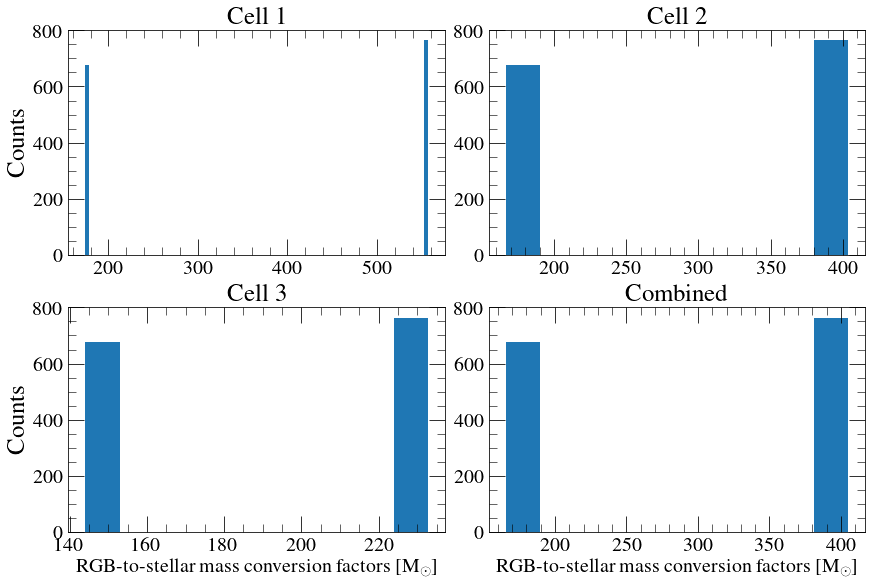

In [6]:
plt.figure(figsize=(12,8), facecolor='white', constrained_layout=True)

plt.subplot(2,2,1)
plt.title('Cell 1', fontsize=25)
plt.hist(isofacs1, 100)
# plt.xlabel('RGB-to-stellar mass conversion factors', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,2,2)
plt.title('Cell 2', fontsize=25)
plt.hist(isofacs2, 10)
# plt.xlabel('RGB-to-stellar mass conversion factors', fontsize=25)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,2,3)
plt.title('Cell 3', fontsize=25)
plt.hist(isofacs3, 10)
plt.ylabel('Counts', fontsize=25)
plt.xlabel('RGB-to-stellar mass conversion factors [M$_{\odot}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,2,4)
plt.title('Combined', fontsize=25)
plt.hist(isofacs_comb, 10)
plt.xlabel('RGB-to-stellar mass conversion factors [M$_{\odot}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()


In [ ]:
def average_mass(iso, lowfehgrid=True):
    """
    find the average mass for a given slice of the isochrone recarray
    """
    if lowfehgrid:
        agekey = 'logAge'
        Zkey = 'Zini'
        Mkey = 'Mini'
    else:
        agekey = 'logageyr'
        Zkey = 'Z_ini'
        Mkey = 'M_ini'
    weights = iso['deltaM']*(10**(iso[agekey]-9)/iso[Zkey])
    return np.sum(iso[Mkey]*weights)/np.sum(weights)

def mass_ratio(iso, lowfehgrid=True, minjk=0.3, maxjk=9999.):
    """
    find the mass ratio between stars in the cuts adopted for giants in APOGEE, and the rest of the isochrones
    """
    if lowfehgrid:
        agekey = 'logAge'
        Zkey = 'Zini'
        Mkey = 'Mini'
        jkey, kkey= 'Jmag', 'Ksmag'
        teff = 'logTe'
    else:
        agekey = 'logageyr'
        Zkey = 'Z_ini'
        Mkey = 'M_ini'
        jkey, kkey= 'J', 'K'
        teff = 'teff'
        
    weights = iso['deltaM']*(10**(iso[agekey]-9)/iso[Zkey])
    mask = (iso[jkey]-iso[kkey] > minjk) & (iso[jkey]-iso[kkey] < maxjk) & (iso['logg'] > 0.5) & (iso['logg'] < 3.5) & (10**(iso[teff]) < 5500.) & (10**(iso[teff]) > 4000.)
    return np.sum(iso[Mkey][mask]*weights[mask])/np.sum(iso[Mkey]*weights)


In [133]:
rthetaphigrid = np.mgrid[0.1:10.:200j,0:np.pi:150j,0:2*np.pi:150j]
dr = (10.-0.1)/199
dtheta = (np.pi-0.)/149
dphi = (2*np.pi-0.)/149
shape = np.shape(rthetaphigrid.T)
rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
xyzgrid = np.dstack([x,y,z])[0]
rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]

In [45]:
# fac4, mass4, norm4 = normalisation_from_fixed_profile(masks_c[3], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
#                                                   opt_halo_cell4, fehrange=[-2.,-1.5])

# fac5, mass5, norm5 = normalisation_from_fixed_profile(masks_c[4], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
#                                                   opt_halo_cell5, fehrange=[-1.5,-1.])

# fac6, mass6, norm6 = normalisation_from_fixed_profile(masks_c[5], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
#                                                   opt_halo_cell6, fehrange=[-1.,-0.5])


In [46]:
# fac7, mass7, norm7 = normalisation_from_fixed_profile(masks_c[6], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
#                                                   opt_halo_cell4, fehrange=[-2.,-1.5])

# fac8, mass8, norm8 = normalisation_from_fixed_profile(masks_c[7], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
#                                                   opt_halo_cell5, fehrange=[-1.5,-1.])

# fac9, mass9, norm9 = normalisation_from_fixed_profile(masks_c[8], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
#                                                   opt_halo_cell6, fehrange=[-1.,-0.5])


In [149]:
def plummer(r, a):
    d = (3./4.*np.pi*a**3) * (1. + (r**2/a**2))**(-5./2.)
    return d

In [150]:
dr = (10.-0.1)/199
dtheta = (np.pi-0.)/149
dphi = (2*np.pi-0.)/149

25031.85727402009

In [164]:
# define the shell volumes for which to integrate the mass and density over
rs = np.linspace(0.1,10,200)
shell_volumes = np.zeros(len(rs))
dr = (10-0.1)/199
d1 = [plummer(i, opt_plummer_cell1[0]) for i in rs]
d2 = [plummer(i, opt_plummer_cell2[0]) for i in rs]
d3 = [plummer(i, opt_plummer_cell3[0]) for i in rs]

In [167]:
opt_plummer_cell2[0]

3.1100638358489707

In [180]:
mass1 = 9.5e8
mass2 = 9.7e8
mass3 = 9.3e8

In [177]:
np.sum(np.array(d1)*mass1*dr*dtheta*dphi)

875543030.9092872

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


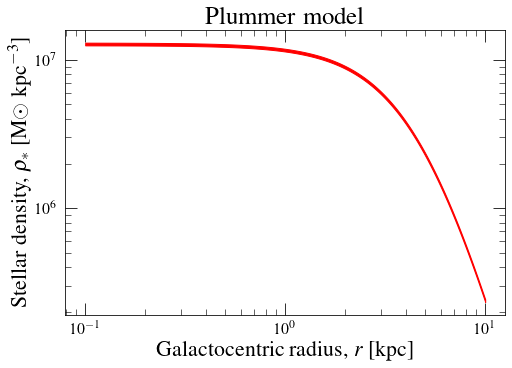

In [195]:
plt.figure(figsize=(7,5), constrained_layout=True, facecolor='white')

plt.title('Plummer model', fontsize=25)
plt.fill_between(rs,np.array(d1)*mass2*dr*dtheta*dphi,np.array(d1)*mass3*dr*dtheta*dphi, color='r')
# plt.plot(rs,np.array(d1)*mass1*dr*dtheta*dphi, lw=3,color='darkred')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Galactocentric radius, $r$ [kpc]',fontsize=22)
plt.legend(fontsize=18,ncol=2,loc='upper center',frameon=False)
plt.ylabel(r'Stellar density, $\rho_{*}$ [M$\odot$ kpc$^{-3}$]',fontsize=22)
plt.yscale('log')
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.savefig('../plots/density-all-notright.pdf', format='pdf', dpi=200, bbox_inches='tight')


In [202]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[0.1:10:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (10-0.1)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(1.5,20,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.**2+0.02**2)
                alpha = param[0]
                max_r = 10.
                min_r = 0.1
                r = np.linspace(0.1,10,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
    return halomasses

In [203]:
cell1mass = calc_masses(densprofiles.plummer_axi, facs_plummer_cell1, samples_plummer_cell1)


0it [00:00, ?it/s]

In [205]:
cell1m = np.sum(cell1mass,axis=1)*(10-0.1)/149
print(np.percentile(cell1m,[16,50,84]))


[4.80192556e+09 6.02033013e+09 7.19633967e+09]


In [207]:
cell1m.shape

(300,)

In [208]:
# define the shell volumes for which to integrate the mass and density over
rs = np.linspace(0.1,10,150)
shell_volumes = np.zeros(len(rs))
dr = (10-0.1)/149
shell_volumes = [((4*np.pi)/3)*(i+dr)**3-((4*np.pi)/3)*(i)**3 for i in rs]

shell_c1masses = cell1mass/shell_volumes


In [209]:
percentiles_c1_masses_shell = np.percentile(shell_c1masses,[16,50,84], axis=0)


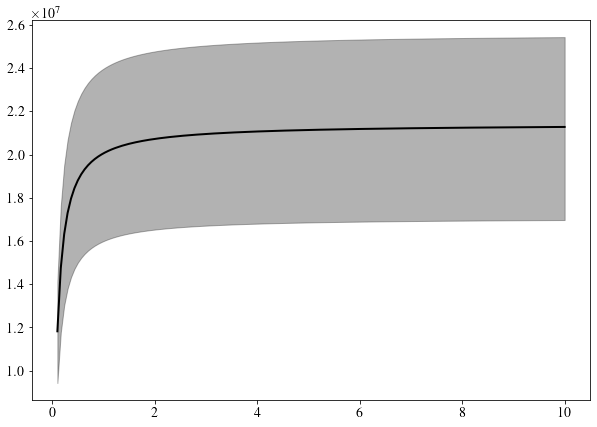

In [210]:
plt.figure(figsize=(10,7))
plt.rc('font',family='serif',size=14)
plt.plot(rs,percentiles_c1_masses_shell[1],label='Halo',c='k',lw=2)
plt.fill_between(rs,percentiles_c1_masses_shell[0],percentiles_c1_masses_shell[2],alpha=0.3,color='k')


# Get the uncertainty on the mass by using the percentiles on the samples of the parameters in the model

In [53]:
opt1 = np.percentile(samples_plummer_cell1, [16,50,84], axis=0)
opt2 = np.percentile(samples_plummer_cell2, [16,50,84], axis=0)
opt3 = np.percentile(samples_plummer_cell3, [16,50,84], axis=0)
opt_comb = np.percentile(samples_plummer_comb, [16,50,84], axis=0)


In [51]:
opt1[0]

array([4.79796592, 0.75545558, 0.73197759])

In [56]:
fac1, mass1, norm1, t1 = normalisation_from_fixed_profile(masks_c[0], outarea, densprofiles.plummer_axi,\
                                                  opt1[0], fehrange=[-2.,-1.5])

fac2, mass2, norm2, t2 = normalisation_from_fixed_profile(masks_c[1], outarea, densprofiles.plummer_axi,\
                                                  opt2[0], fehrange=[-1.5,-1.])

fac3, mass3, norm3, t3 = normalisation_from_fixed_profile(masks_c[2], outarea, densprofiles.plummer_axi,\
                                                  opt3[0], fehrange=[-1.,-0.5])
fac_comb, mass_comb, norm_comb, t_comb = normalisation_from_fixed_profile(mask_tot, outarea, densprofiles.plummer_axi,\
                                                  opt_comb[0], fehrange=[-2.,-0.5])
# upper bound
print(mass1, mass2, mass3)
print(mass1+mass2+mass3)
print(mass_comb)


177754223.20229813 740152814.6590006 60094378.977655284
978001416.8389541
923461091.6445469


In [55]:
fac1, mass1, norm1, t1 = normalisation_from_fixed_profile(masks_c[0], outarea, densprofiles.plummer_axi,\
                                                  opt1[2], fehrange=[-2.,-1.5])

fac2, mass2, norm2, t2 = normalisation_from_fixed_profile(masks_c[1], outarea, densprofiles.plummer_axi,\
                                                  opt2[2], fehrange=[-1.5,-1.])

fac3, mass3, norm3, t3 = normalisation_from_fixed_profile(masks_c[2], outarea, densprofiles.plummer_axi,\
                                                  opt3[2], fehrange=[-1.,-0.5])
fac_comb, mass_comb, norm_comb, t_comb = normalisation_from_fixed_profile(mask_tot, outarea, densprofiles.plummer_axi,\
                                                  opt_comb[2], fehrange=[-2.,-0.5])

# lower bound
print(mass1, mass2, mass3)
print(mass1+mass2+mass3)
print(mass_comb)


168845895.2858462 705581457.230216 40830866.292350635
915258218.8084129
892673432.19414


In [57]:
fac1, mass1, norm1, t1 = normalisation_from_fixed_profile(masks_c[0], outarea, densprofiles.plummer_axi,\
                                                  opt1[1], fehrange=[-2.,-1.5])

fac2, mass2, norm2, t2 = normalisation_from_fixed_profile(masks_c[1], outarea, densprofiles.plummer_axi,\
                                                  opt2[1], fehrange=[-1.5,-1.])

fac3, mass3, norm3, t3 = normalisation_from_fixed_profile(masks_c[2], outarea, densprofiles.plummer_axi,\
                                                  opt3[1], fehrange=[-1.,-0.5])
fac_comb, mass_comb, norm_comb, t_comb = normalisation_from_fixed_profile(mask_tot, outarea, densprofiles.plummer_axi,\
                                                  opt_comb[1], fehrange=[-2.,-0.5])
# upper bound
print(mass1, mass2, mass3)
print(mass1+mass2+mass3)
print(mass_comb)


173342629.23552445 722166744.6936601 49721761.709007986
945231135.6381925
907305126.8535253


In [ ]:
rthetaphigrid = np.mgrid[0.1:10.:200j,0:np.pi:150j,0:2*np.pi:150j]
dr = (10.-0.1)/199
dtheta = (np.pi-0.)/149
dphi = (2*np.pi-0.)/149
shape = np.shape(rthetaphigrid.T)
rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
xyzgrid = np.dstack([x,y,z])[0]
rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]

In [ ]:
rphizgrid

In [ ]:
b1 = np.sum(np.sum(a1,axis=2),axis=1)
b1.shape

In [ ]:
plt.plot(b1)

In [ ]:
a1 = t1.reshape(200,150,150)
b1 = np.sum(np.sum(a1,axis=2),axis=1)
b1

In [ ]:
def plummer(r, a):
    d = (3./4.*np.pi*a**3) * (1. + (r**2/a**2))**(-5./2.)
    return d

In [ ]:
tes = []
for i in shell_volumes:
    tes.append(plummer(i, opt_plummer_cell1[0]))

In [ ]:
plt.plot(rs, np.array(tes)*dr*b1)
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
# define the shell volumes for which to integrate the mass and density over
rs = np.linspace(0.1,10,200)
shell_volumes = np.zeros(len(rs))
dr = (10-0.1)/199
shell_volumes = [plummer(i+dr, opt_plummer_cell1[0]) - plummer(i, opt_plummer_cell1[0]) for i in rs]
# shell_volumes = [((4*np.pi)/3)*(i+dr)**3-((4*np.pi)/3)*(i)**3 for i in rs]
print(shell_volumes)


In [ ]:
np.sum(np.array(dens1)*mass1)

In [ ]:
plt.plot(rs, np.array(dens1)*mass1)
plt.xscale('log')
plt.yscale('log')


In [ ]:
rthetaphigrid = np.mgrid[0.1:10.:200j,0:np.pi:150j,0:2*np.pi:150j]
dr = (10.-0.1)/199
dtheta = (np.pi-0.)/149
dphi = (2*np.pi-0.)/149
shape = np.shape(rthetaphigrid.T)
rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
# x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
# y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
# z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
# xyzgrid = np.dstack([x,y,z])[0]
# rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
# rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]


In [ ]:
rphizdens1 = t1.reshape(200,150,150)
deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
a1 = t1*deltafactor
a1 = a1.reshape(150,150,200).T
np.sum(a1), mass1

In [ ]:
def plummer(r, a):
    d = (3./4.*np.pi*a**3) * (1. + (r**2/a**2))**(-5./2.)
    return d

In [ ]:
# define the shell volumes for which to integrate the mass and density over
rs = np.linspace(0.1,10,200)
shell_volumes = np.zeros(len(rs))
dr = (10-0.1)/199
shell_volumes = [plummer(i+dr, opt_plummer_cell1[0]) - plummer(i, opt_plummer_cell1[0]) for i in rs]
# shell_volumes = [((4*np.pi)/3)*(i+dr)**3-((4*np.pi)/3)*(i)**3 for i in rs]
print(shell_volumes)
plt.plot(rs, -mass1/shell_volumes*dr)
# plt.xscale('log')
# plt.yscale('log')


In [ ]:
np.sum(b1/shell_volumes*dr)

In [ ]:
from scipy.constants import G
from astropy import units as u

In [ ]:
gconst = G*u.N * u.m**2 / u.kg**2


In [ ]:
g = gconst.to(u.N * u.kpc**2/ u.Msun**2)

In [ ]:
opt_plummer_cell1[0]*u.kpc

In [ ]:
rs = np.linspace(0.1,5,128)*u.kpc

#v_circ^2/r = partder(phi)/partder(r)

vc1 = []
vc2 = []
vc3 = []
for i in rs:
    vc11 = (np.sqrt(g * (2e10 * u.Msun) * i**2/ (i**2 + (opt_plummer_cell1[0]*u.kpc)**2)**(3./2.)))
    vc1.append(vc11.to(u.km/u.s))
    vc22 = (np.sqrt(g * (2e10 * u.Msun) * i**2/ (i**2 + (opt_plummer_cell2[0]*u.kpc)**2)**(3./2.)))
    vc2.append(vc22.to(u.km/u.s))
    vc33= (np.sqrt(g * (2e10 * u.Msun) * i**2/ (i**2 + (opt_plummer_cell3[0]*u.kpc)**2)**(3./2.)))
    vc3.append(vc33.to(u.km/u.s))
    

In [ ]:
rs2 = np.linspace(5,30,128)
vc_eilers = []
for i in rs2:
    vc_eilers.append(229. - 1.7*i)


In [ ]:
plt.plot(rs, u.Quantity(vc1), color='r', lw=3)
plt.plot(rs, u.Quantity(vc2), color='firebrick', lw=3)
plt.plot(rs, u.Quantity(vc3), color='maroon', lw=3)
plt.plot(rs, u.Quantity(vc3), color='maroon', lw=3)
# plt.plot(rs2, vc_eilers, color='k', lw=3, ls='dashed')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0.1,5)
plt.ylabel('Rotation curve', fontsize=20)
plt.xlabel('Galactocentric radius, $r$ (kpc)', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


# Can we calculate the mass of Sag A$^{*}$

In [ ]:
vR = data['vR']*220.
vphi = data['vT']*220.
vz = data['vZ']*220.


In [ ]:
vall = np.sqrt(vR**2 + vphi**2 + vz**2)

In [ ]:
vall1 = np.sum(vall[masks_c[0]])/len(vall[masks_c[0]])
vall2 = np.sum(vall[masks_c[1]])/len(vall[masks_c[1]])
vall3 = np.sum(vall[masks_c[2]])/len(vall[masks_c[2]])

In [ ]:
vall1, vall2, vall3

In [ ]:
#faber jackson relation

vdisp1 = np.std(data['VHELIO_AVG'][masks_c[0]])
vdisp2 = np.std(data['VHELIO_AVG'][masks_c[1]])
vdisp3 = np.std(data['VHELIO_AVG'][masks_c[2]])


In [ ]:
vdisp1, vdisp2, vdisp3

In [ ]:
vdisp = np.linspace(50,300, 128)
masses_o = []

A = 2.84
B = 7.54

for i in vdisp:
    masses_o.append(A*np.log10(i/200.) + B)


In [ ]:
mass_o1 = A *np.log10(vdisp1/200.) + B
mass_o2 = A *np.log10(vdisp2/200.) + B
mass_o3 = A *np.log10(vdisp3/200.) + B

In [ ]:
'{:.2e}'.format(10**mass_o1), '{:.2e}'.format(10**mass_o2), '{:.2e}'.format(10**mass_o3)

In [ ]:
# plt.plot(vdisp,masses_fj)
plt.plot(vdisp,10**np.array(masses_o))
# plt.scatter(vdisp1, mass_fj1,c='k')
# plt.scatter(vdisp2, mass_fj2,c='b')
# plt.scatter(vdisp3, mass_fj3,c='g')
plt.scatter(vdisp1, 10**mass_o1,c='k')
plt.scatter(vdisp2, 10**mass_o2,c='b')
plt.scatter(vdisp3, 10**mass_o3,c='g')
plt.xscale('log')
plt.yscale('log')


In [ ]:
mass_fj1, mass_o1,mass_fj2, mass_o2,mass_fj3, mass_o3

In [ ]:
massses = np.linspace(1e11,1e13, 128)*u.Msun
h0 = 70.*u.km/u.s/u.Mpc
sigmavs = []

for i in massses:
    s = ((200./2)**(1./6.)*(h0*g*i)**(1./3.)).to(u.km/u.s)
    sigmavs.append(s)



In [ ]:
vdisp = np.linspace(50,300, 128)*u.km/u.s

masses_gal = []

for i in vdisp:
    m = (i**2/g * 5.*u.kpc * 5).to(u.Msun)
    masses_gal.append(m)

In [ ]:
plt.plot(u.Quantity(vdisp),u.Quantity(masses_gal))
plt.xscale('log')
plt.yscale('log')
plt.vlines(vdisp1,1e10,1e12)
plt.vlines(vdisp2,1e10,1e12)
plt.vlines(vdisp3,1e10,1e12)
plt.ylim(1e10,1e12)
plt.xlim(50,300)

In [ ]:
plt.plot(u.Quantity(sigmavs),u.Quantity(massses))
plt.vlines(vdisp1,1e11,1e14)
plt.vlines(vdisp2,1e11,1e14)
plt.vlines(vdisp3,1e11,1e14)
plt.xscale('log')
plt.yscale('log')


In [ ]:
print(u.Quantity(sigmavs[25]),'{:.2e}'.format(u.Quantity(massses[25])))
print(u.Quantity(sigmavs[22]),'{:.2e}'.format(u.Quantity(massses[22])))
print(u.Quantity(sigmavs[12]),'{:.2e}'.format(u.Quantity(massses[12])))


In [ ]:
vdisp1, vdisp2, vdisp3

In [ ]:
percentiles_halo_masses_shell.shape

In [ ]:
fac4, mass4, norm4 = normalisation_from_fixed_profile(masks_c[3], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  opt_halo_cell4, fehrange=[-2.,-1.5])

fac5, mass5, norm5 = normalisation_from_fixed_profile(masks_c[4], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  opt_halo_cell5, fehrange=[-1.5,-1.])

fac6, mass6, norm6 = normalisation_from_fixed_profile(masks_c[5], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  opt_halo_cell6, fehrange=[-1.,-0.5])

fac7, mass7, norm7 = normalisation_from_fixed_profile(masks_c[6], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  opt_halo_cell7, fehrange=[-2.,-1.5])

fac8, mass8, norm8 = normalisation_from_fixed_profile(masks_c[7], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  opt_halo_cell8, fehrange=[-1.5,-1.])

fac9, mass9, norm9 = normalisation_from_fixed_profile(masks_c[8], outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,\
                                                  opt_halo_cell9, fehrange=[-1.,-0.5])

In [ ]:
mass8

In [ ]:
masses = np.array([mass1, mass2, mass3, mass4[0], mass5[0], mass6[0], mass7[0], mass8[0], mass9[0]]).reshape(3,3)

In [ ]:
fig = plt.figure(figsize=(8,6), constrained_layout=True)

fig.suptitle('Stellar mass of the chemically unevolved Milky Way',fontsize=30,x=0.6,y=1.12)

plt.scatter(data['FE_H'][mask&mask_une],data['MG_FE'][mask&mask_une],s=5,c='k', alpha=0.3)
color = plt.imshow(np.log10(masses),cmap=cm.bubblegum, vmin=7.5,vmax=9.5, extent=(-2.,-0.5,-0.15,0.45), aspect='auto')
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlim(-1,0.5)
plt.ylim(-0.4,0.6)
plt.hlines(0.45,-2,-0.5,color='k',lw=1.5,ls='dashed')
plt.hlines(0.25,-2,-0.5,color='k',lw=1.5,ls='dashed')
plt.hlines(0.05,-2,-0.5,color='k',lw=1.5,ls='dashed')
plt.hlines(-0.15,-2,-0.5,color='k',lw=1.5,ls='dashed')
plt.vlines(-2,-0.15,0.45,color='k',lw=1.5,ls='dashed')
plt.vlines(-1.5,-0.15,0.45,color='k',lw=1.5,ls='dashed')
plt.vlines(-1.,-0.15,0.45,color='k',lw=1.5,ls='dashed')
plt.vlines(-0.5,-0.15,0.45,color='k',lw=1.5,ls='dashed')
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Mg/Fe]', fontsize=30)
plt.xlim(-2.1,-0.4)
plt.ylim(-0.25,0.55)
cbar_ax = fig.add_axes([1.05,0.145,0.04,0.85])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='vertical')
cbar.set_label(label=r'log$_{10}$($M_{*}$) [M$_{\odot}$]',fontsize=30, labelpad=12)
cbar.ax.tick_params(labelsize=25)
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')


plt.savefig('../plots/mass-cells.pdf', format='pdf', dpi=200, bbox_inches='tight')


In [ ]:
mass2

In [ ]:
rs = np.linspace(0.1,10.,200)
dr = (10-0.1)/199

dens_plummer1 = []
dens_plummer2 = []
dens_plummer3 = []

for indx, i in enumerate(rs):
    dens_plummer1.append(3.*mass1/(4.*np.pi*opt_plummer_cell1[0]**3) * (1. + ((i)**2/opt_plummer_cell1[0]**2))**(-5./2.))
    dens_plummer2.append(3.*mass2/(4.*np.pi*opt_plummer_cell2[0]**3) * (1. + ((i)**2/opt_plummer_cell2[0]**2))**(-5./2.))
    dens_plummer3.append(3.*mass3/(4.*np.pi*opt_plummer_cell3[0]**3) * (1. + ((i)**2/opt_plummer_cell3[0]**2))**(-5./2.))



In [ ]:
np.sum(np.array(dens_plummer1))

In [ ]:
# avg = (np.array(dens_plummer1)+np.array(dens_plummer2)+np.array(dens_plummer3))
print(np.sum(avg))
plt.plot(rs, dens_plummer1)
# plt.plot(rs, dens_plummer2)
# plt.plot(rs, dens_plummer3)
plt.xscale('log')
plt.yscale('log')


In [ ]:
print(mass1+ mass2+mass3)

print(mass4[0]+mass5[0]+mass6[0]+mass7[0]+mass8[0]+mass9[0])

In [ ]:
mass5[0]+mass6[0]

In [ ]:
mass7[0]+mass8[0]+mass9[0]

# For cells 1-3, compute the rotation curve and potential for a plummer model

In [ ]:
from scipy.constants import G

In [ ]:
opts_cell2 = np.percentile(samples_plummer_cell2, [16,50,84], axis=0)
cell2_a = opts_cell2[1,0]

rs = np.linspace(0.01,50,128)
vc_cell2 = []
pot_cell2 = []

for indx, i in enumerate(rs):
    a = np.sqrt(cell2_a**2 + i**2)
    vc_cell2.append(np.sqrt(G * mass2 * i**2/(cell2_a + a)**2*a))
    pot_cell2.append( -G*mass2/(cell2_a + np.sqrt(cell2_a**2 + i**2)))


In [ ]:
plt.plot(rs, pot_cell2)


In [ ]:
plt.plot(rs, vc_cell2)


In [ ]:
print(mass7)
print(mass8)
print(mass9)

In [ ]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[0.1:40:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (40-0.1)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(0.1,40,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.275**2+0.02**2)
                alpha = param[0]
                max_r = 12.
                min_r = 0.1
                r = np.linspace(0.1,40,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)*facs[ii]
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens
    return halomasses


In [ ]:
mass = calc_masses(densprofiles.plummer_axi, facs_plummer_cell2, samples_plummer_cell2)

In [ ]:
# calculate the mass in 25kpc from halo 
print('Within 40 kpc')
mass1 = np.nansum(mass,axis=1)*(40-0.1)/149
print(np.nanpercentile(mass1,[16,50,84]))
# calculate the mass in 6kpc from halo
print('Within 5 kpc')
mass1 = np.nansum(mass[:,:49],axis=1)*(40-0.1)/149
print(np.nanpercentile(mass1,[16,50,84]))

